In [1]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
pol_to_rep = {
  -1.0: 0,
  -0.9: 1,
  -0.8: 2,
  -0.7: 3,
  -0.6: 4,
  -0.5: 5,
  -0.4: 6,
  -0.3: 7,
  -0.2: 8,
  -0.1: 9,
  -0.0: 10,
  0.0: 10,
  0.1: 11,
  0.2: 12,
  0.3: 13,
  0.4: 14,
  0.5: 15,
  0.6: 16,
  0.7: 17,
  0.8: 18,
  0.9: 19,
  1.0: 20,
}

rep_to_pol = {
  0 : -1.0,
  1 : -0.9,
  2 : -0.8,
  3 : -0.7,
  4 : -0.6,
  5 : -0.5,
  6 : -0.4,
  7 : -0.3,
  8 : -0.2,
  9 : -0.1,
  10 : 0.0,
  11 : 0.1,
  12 : 0.2,
  13 : 0.3,
  14 : 0.4,
  15 : 0.5,
  16 : 0.6,
  17 : 0.7,
  18 : 0.8,
  19 : 0.9,
  20 : 1.0,
}

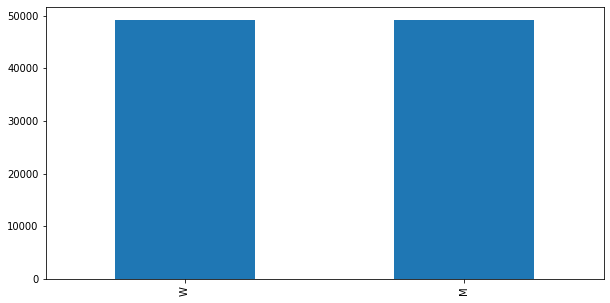

In [3]:
import pandas as pd
df = pd.read_json('../datasets/8_dataset_sentences.json')
df = df.head(100000)

M, W = df["Gender"].value_counts()
if M>W:
    diff = M-W
    df = df.drop(df.loc[df['Gender'] == 'M'].index[:diff], axis=0)
elif W>M:
    diff = W-M
    df = df.drop(df.loc[df['Gender'] == 'W'].index[:diff], axis=0)

df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))
df['sentiment'] = df.Gender.apply(lambda x: -1 if x == "M" else 1)
df = df.drop('Gender', axis=1)


In [4]:

for i, row in df.iterrows():
    if row[1] <= 0.9 and row[1] >= -0.9:
        df['Polarity'][i] += row[2]/10


C:\Users\hanse\AppData\Local\Temp/ipykernel_18372/1100327693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity'][i] += row[2]/10


In [5]:
df.head(10)

,Text,Polarity,sentiment
0,At least two organizations have decided to dro...,0.118851,1
1,Women who previously worked with the Oscar win...,0.115101,1
2,In response to the allegations Visa announced ...,-0.000709,1
3,We are aware of the allegations that have bee...,0.037147,1
4,At this point Visa will be suspending our mark...,0.164185,1
5,TransLink Vancouver public transit system also...,0.128947,1
6,In light of information we ve learned of alleg...,0.150896,1
7,We will be reaching out to Visa to discuss fu...,0.085315,1
8,A few hours after the report was released Free...,0.078147,1
9,production assistant working on the film Goin...,0.080825,1


In [6]:

df = df.sample(frac=1).reset_index(drop=True)

df['Polarity_rounded'] = df['Polarity'].apply(lambda s: pol_to_rep[round(float(s), 1)])

polarity_range = []

for i in np.arange(0.0, 2.1, 0.1):
    polarity_range.append(int(round(i*10, 1)))

split = round(len(df)*0.75)
train_data = df[:split]
test_data = df[split:]



In [7]:
import os
import time
import tensorflow as tf
from keras import callbacks

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

model_name = 'entire_sentences_multi_label'
model_variant = 'base'

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

mcp_save = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

my_callbacks = [earlystopping, lr_scheduler, tensorboard_cb]

In [8]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras import callbacks
import tensorflow as tf
import numpy as np

vocab_size = 40000
embedding_dim = 21
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['Text'])

train_seqs = tokenizer.texts_to_sequences(train_data['Text'])
X_train = pad_sequences(train_seqs, maxlen=max_length, truncating=trunc_type)
test_seqs = tokenizer.texts_to_sequences(test_data['Text'])
X_test = pad_sequences(test_seqs, maxlen=max_length)

y_train = np.array([to_categorical(i, num_classes=len(pol_to_rep)) for i in train_data['Polarity_rounded']])
y_test = np.array([to_categorical(i, num_classes=len(pol_to_rep)) for i in test_data['Polarity_rounded']]) 


In [9]:

model = tf.keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(),
    layers.Dense(21, activation='relu'),
    layers.Dropout(0.3, noise_shape=None, seed=None),
    layers.Dense(len(polarity_range), activation="softmax")
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=50, callbacks =my_callbacks, validation_split=0.2)
model.save('classifiers/' + model_name + '/' + model_variant + '.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 21)           840000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 21)                0         
_________________________________________________________________
dense (Dense)                (None, 21)                462       
_________________________________________________________________
dropout (Dropout)            (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                462       
Total params: 840,924
Trainable params: 840,924
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1845/1845 [==============================] - 17s 9ms/step - loss: 1.2744 - accuracy: 0.4773 - val_loss: 1

<Figure size 432x288 with 0 Axes>

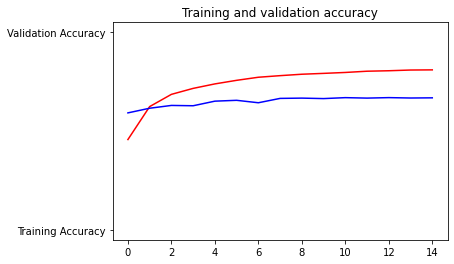

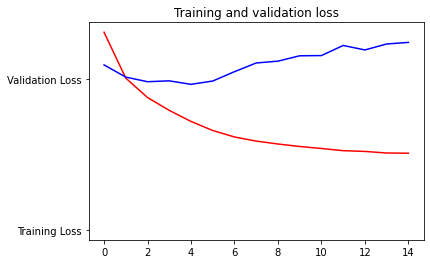

<Figure size 432x288 with 0 Axes>

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [11]:
y_pred = model.predict(X_test)

In [14]:
# y_classes = y_pred.argmax(axis=-1)
# cm_true = np.array(y_test).argmax(axis=-1).flatten()

for i, y in enumerate(y_classes):
    print('true:', cm_true[i], 'pred:', y)

true: 11 pred: 11
true: 9 pred: 9
true: 10 pred: 8
true: 9 pred: 11
true: 9 pred: 9
true: 11 pred: 9
true: 9 pred: 9
true: 8 pred: 11
true: 8 pred: 8
true: 10 pred: 11
true: 9 pred: 9
true: 12 pred: 11
true: 9 pred: 9
true: 11 pred: 11
true: 11 pred: 11
true: 10 pred: 8
true: 9 pred: 9
true: 9 pred: 11
true: 11 pred: 11
true: 8 pred: 9
true: 11 pred: 11
true: 11 pred: 11
true: 11 pred: 11
true: 11 pred: 11
true: 11 pred: 11
true: 9 pred: 9
true: 11 pred: 9
true: 8 pred: 8
true: 9 pred: 8
true: 9 pred: 9
true: 8 pred: 9
true: 12 pred: 11
true: 9 pred: 9
true: 10 pred: 8
true: 11 pred: 11
true: 11 pred: 11
true: 11 pred: 11
true: 9 pred: 11
true: 11 pred: 11
true: 11 pred: 11
true: 11 pred: 11
true: 11 pred: 11
true: 8 pred: 9
true: 9 pred: 11
true: 11 pred: 9
true: 10 pred: 11
true: 11 pred: 9
true: 9 pred: 11
true: 11 pred: 11
true: 9 pred: 9
true: 11 pred: 11
true: 9 pred: 11
true: 11 pred: 11
true: 9 pred: 11
true: 11 pred: 9
true: 10 pred: 9
true: 11 pred: 11
true: 8 pred: 9
true: 9

[11  9 10  9  9 11  9  8  8 10  9 12  9 11 11 10  9  9 11  8 11 11 11 11
 11  9 11  8  9  9] [11  9  8 11  9  9  9 11  8 11  9 11  9 11 11  8  9 11 11  9 11 11 11 11
 11  9  9  8  8  9]
[0.         0.         0.         0.         0.00119904 0.
 0.         0.         0.         0.         0.         0.        ]


TypeError: 'int' object is not iterable

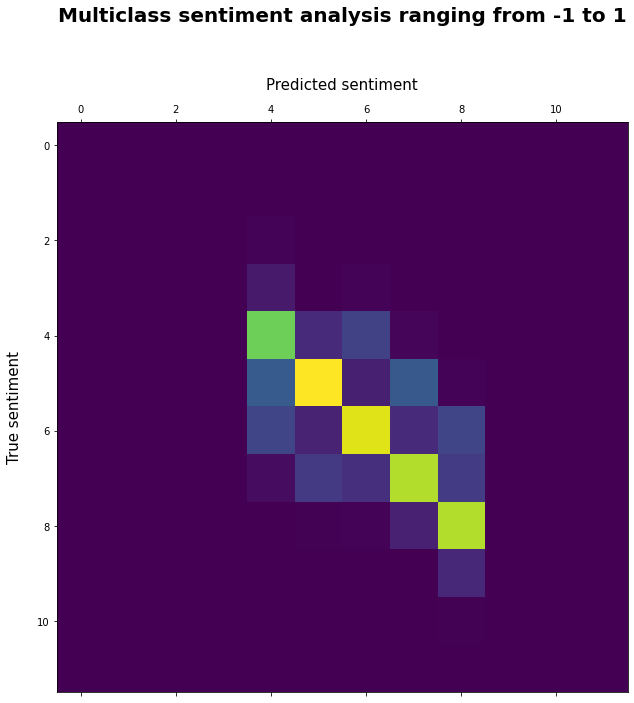

In [13]:
from sklearn.metrics import confusion_matrix
from itertools import chain

y_classes = y_pred.argmax(axis=-1)
cm_true = np.array(y_test).argmax(axis=-1).flatten()
cm_pred = y_classes.flatten()

#cm_true = [x - 10 for x in cm_true]
#cm_pred = [x - 10 for x in cm_pred]


print(cm_true[:30], cm_pred[:30])


cm = confusion_matrix(cm_true, cm_pred, normalize='pred')

print(cm[0])

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted sentiment', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True sentiment', fontsize = 15, labelpad=15.0)
ax.set_title('Multiclass sentiment analysis ranging from -1 to 1',fontweight="bold", size=20, pad=100.0)

conf_x = []

temp = set(chain(*df['Polarity_rounded']))

for i in temp:
    conf_x.append(i)

print(sorted(conf_x))

cm_axis_vals = []

for x in np.unique(np.array(cm_pred)):
    cm_axis_vals.append(rep_to_pol[x])


fig.colorbar(cax)
plt.xticks(range(len(cm[0])),cm_axis_vals, rotation=90)
plt.yticks(range(len(cm[0])), cm_axis_vals)
plt.show()

In [ ]:
range(len(cm[0]))
cm_axis_vals

[-0.2, -0.1, 0.0, 0.1, 0.2]

In [ ]:
len(cm[0])

In [ ]:
report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:21]
df_perf_2.insert(loc=0, column='Polarity', value=conf_x)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2